## Loading Modules and Setting Up Environment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier

from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)

import shap

plt.style.use("default")
warnings.filterwarnings("ignore")


c:\Users\HP\Documents\10-Academy\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_PATH = "../data/processed/acis_processed.csv" 
df = pd.read_csv(DATA_PATH)

df.head()


,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims
0,145249,12827,2015-03-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
1,145249,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
2,145249,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0
3,145255,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.848070,0.0
4,145255,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0


In [3]:
df["has_claim"] = df["TotalClaims"] > 0
df["claim_severity"] = np.where(df["has_claim"], df["TotalClaims"], np.nan)
df["margin"] = df["TotalPremium"] - df["TotalClaims"]


## Data preparation for modeling

In [4]:
feature_cols_num = [
    "CustomValueEstimate",
    "SumInsured",
    "TotalPremium",
    "CalculatedPremiumPerTerm",
    "CapitalOutstanding",
    # "NumberOfVehiclesInFleet",
]

feature_cols_cat = [
    "Province",
    "PostalCode",
    "VehicleType",
    "Model",
    "Gender",
    "CoverType",
]


Drop rows with missing values in these columns for now:

In [5]:
model_cols = feature_cols_num + feature_cols_cat + ["TotalClaims", "has_claim", "claim_severity"]
data = df[model_cols]

In [6]:
# Fill the missing values in categorical features with 'Unknown'
for col in feature_cols_cat:
    data[col] = data[col].fillna('Unknown')

# there are commas in some numeric columns, remove them and convert to numeric
for col in feature_cols_num:
    if data[col].dtype == 'object':
        data[col] = data[col].str.replace(',', '')
        data[col] = pd.to_numeric(data[col], errors='coerce')

# Fill the missing values in numerical features with the median of each column
for col in feature_cols_num:
    data[col] = data[col].fillna(data[col].median())

Build a common preprocessor for all models:

In [7]:
preprocessor1 = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), feature_cols_num),
        ("cat", OneHotEncoder(handle_unknown="ignore"), feature_cols_cat),
    ]
)


## Model 1: Claim severity regression

Only policies with a claim (TotalClaims > 0). Target is TotalClaims. Evaluation: RMSE and R squared. 

In [8]:
severity_df = data[data["has_claim"]].copy()

X_sev = severity_df[feature_cols_num + feature_cols_cat]
y_sev = severity_df["TotalClaims"]

X_train_sev, X_test_sev, y_train_sev, y_test_sev = train_test_split(
    X_sev, y_sev, test_size=0.2, random_state=42
)


### Linear Regression baseline

In [9]:
linreg_sev = Pipeline(
    steps=[
        ("preprocess", preprocessor1),
        ("model", LinearRegression()),
    ]
)

linreg_sev.fit(X_train_sev, y_train_sev)

y_pred_lin = linreg_sev.predict(X_test_sev)
rmse_lin = np.sqrt(mean_squared_error(y_test_sev, y_pred_lin))
r2_lin = r2_score(y_test_sev, y_pred_lin)
rmse_lin, r2_lin


(np.float64(38235.10584074988), 0.09098389771591664)

### Random Forest

In [10]:
rf_sev = Pipeline(
    steps=[
        ("preprocess", preprocessor1),
        ("model", RandomForestRegressor(
            n_estimators=200,
            max_depth=None,
            random_state=42,
            n_jobs=-1,
        )),
    ]
)

rf_sev.fit(X_train_sev, y_train_sev)

y_pred_rf = rf_sev.predict(X_test_sev)
rmse_rf = np.sqrt(mean_squared_error(y_test_sev, y_pred_rf))
r2_rf = r2_score(y_test_sev, y_pred_rf)
rmse_rf, r2_rf


(np.float64(40502.99836339333), -0.020049698452276887)

### XGBoost regressor

In [11]:
xgb_sev = Pipeline(
    steps=[
        ("preprocess", preprocessor1),
        ("model", XGBRegressor(
            n_estimators=250,
            learning_rate=0.008,
            max_depth=2,
            subsample=0.37,
            colsample_bytree=0.643,
            random_state=2,
            objective="reg:squarederror",
            n_jobs=-1,
        )),
    ]
)

xgb_sev.fit(X_train_sev, y_train_sev)

y_pred_xgb = xgb_sev.predict(X_test_sev)
rmse_xgb = np.sqrt(mean_squared_error(y_test_sev, y_pred_xgb))
r2_xgb = r2_score(y_test_sev, y_pred_xgb)
rmse_xgb, r2_xgb


(np.float64(34295.54217752166), 0.2686549455400935)

Create a small comparison table:

In [12]:
sev_results = pd.DataFrame(
    {
        "model": ["LinearRegression", "RandomForest", "XGBRegressor"],
        "rmse": [rmse_lin, rmse_rf, rmse_xgb],
        "r2": [r2_lin, r2_rf, r2_xgb],
    }
)
sev_results


,model,rmse,r2
0,LinearRegression,38235.105841,0.090984
1,RandomForest,40502.998363,-0.020050
2,XGBRegressor,34295.542178,0.268655


As shown in the table above, the XGBoost model outperforms both the Linear Regression and Random Forest models in predicting claim severity. The lower RMSE indicates that the XGBoost model has better accuracy, while the higher R-squared value suggests it explains a greater proportion of variance in the target variable.

## Model 2: Premium prediction model

Naive target is CalculatedPremiumPerTerm. 

In [13]:
feature_cols_num = [
    "CustomValueEstimate",
    "SumInsured",
    "TotalPremium",
    # "CalculatedPremiumPerTerm",
    "CapitalOutstanding",
    "TotalClaims",
]

feature_cols_cat = [
    "Province",
    "PostalCode",
    "VehicleType",
    "Model",
    "Gender",
    "CoverType",
]
preprocessor2 = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), feature_cols_num),
        ("cat", OneHotEncoder(handle_unknown="ignore"), feature_cols_cat),
    ]
)


In [14]:
premium_df = data.copy()

X_prem = premium_df[feature_cols_num + feature_cols_cat]
y_prem = premium_df["CalculatedPremiumPerTerm"]

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(
    X_prem, y_prem, test_size=0.2, random_state=42
)


In [15]:
# Define helper function to train and evaluate regressors:

def eval_regressor(model_name, model):
    model.fit(X_train_p, y_train_p)
    preds = model.predict(X_test_p)
    rmse = np.sqrt(mean_squared_error(y_test_p, preds))
    r2 = r2_score(y_test_p, preds)
    print(f'{model_name} - RMSE: {rmse}, R2: {r2}')
    return model_name, rmse, r2


In [16]:
models_p = []

lin_p = Pipeline([("preprocess", preprocessor2), ("model", LinearRegression())])
models_p.append(eval_regressor("LinearRegression", lin_p))

rf_p = Pipeline([("preprocess", preprocessor2), ("model", RandomForestRegressor(
    n_estimators=4, random_state=42, n_jobs=-1))])
models_p.append(eval_regressor("RandomForest", rf_p))

xgb_p = Pipeline([("preprocess", preprocessor2), ("model", XGBRegressor(
    n_estimators=150, learning_rate=0.1, max_depth=32,
    subsample=0.6, colsample_bytree=0.8, random_state=2,
    objective="reg:squarederror", n_jobs=-1,))])
models_p.append(eval_regressor("XGBRegressor", xgb_p))

prem_results = pd.DataFrame(models_p, columns=["model", "rmse", "r2"])
prem_results


LinearRegression - RMSE: 196.4089666285294, R2: 0.5167600234042531
RandomForest - RMSE: 14.11409987944323, R2: 0.9975045630229971
XGBRegressor - RMSE: 13.881680720576322, R2: 0.9975860718681082


,model,rmse,r2
0,LinearRegression,196.408967,0.516760
1,RandomForest,14.114100,0.997505
2,XGBRegressor,13.881681,0.997586


The best model is XGBoost with RMSE of around 13.88 and R2 of 0.9975.

## Advanced: claim probability model

This is the advanced part suggested in the brief. 

In [17]:
feature_cols_num = [
    "CustomValueEstimate",
    "SumInsured",
    "TotalPremium",
    "CalculatedPremiumPerTerm",
    "CapitalOutstanding",
    "TotalClaims",
]

feature_cols_cat = [
    "Province",
    "PostalCode",
    "VehicleType",
    "Model",
    "Gender",
    "CoverType",
]
preprocessor3 = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), feature_cols_num),
        ("cat", OneHotEncoder(handle_unknown="ignore"), feature_cols_cat),
    ]
)


In [18]:
prob_df = data.copy()

X_prob = prob_df[feature_cols_num + feature_cols_cat]
y_prob = prob_df["has_claim"].astype(int)

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_prob, y_prob, test_size=0.2, random_state=42, stratify=y_prob
)


In [19]:
rf_clf = Pipeline(
    steps=[
        ("preprocess", preprocessor3),
        ("model", RandomForestClassifier(
            n_estimators=300,
            random_state=42,
            n_jobs=-1,
        )),
    ]
)

rf_clf.fit(X_train_c, y_train_c)
y_pred_c = rf_clf.predict(X_test_c)
y_proba_c = rf_clf.predict_proba(X_test_c)[:, 1]

acc = accuracy_score(y_test_c, y_pred_c)
prec = precision_score(y_test_c, y_pred_c)
rec = recall_score(y_test_c, y_pred_c)
f1 = f1_score(y_test_c, y_pred_c)
roc_auc = roc_auc_score(y_test_c, y_proba_c)

acc, prec, rec, f1, roc_auc


(1.0, 1.0, 1.0, 1.0, 1.0)

Conceptually, the risk based premium for a policy can be described as:
```python
risk_based_premium = claim_probability * claim_severity
```


## Model interpretability with SHAP

In [22]:
rf_sev.fit(X_train_sev, y_train_sev)


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [31]:
feature_cols_num = [
    "CustomValueEstimate",
    "SumInsured",
    "TotalPremium",
    "CalculatedPremiumPerTerm",
    "CapitalOutstanding",
    # "NumberOfVehiclesInFleet",
]
preproc = rf_sev.named_steps["preprocess"]
tree_model = rf_sev.named_steps["model"]

# transform training features
X_train_trans = preproc.transform(X_train_sev)

# make dense numeric array
if hasattr(X_train_trans, "toarray"):
    X_train_dense = X_train_trans.toarray()
else:
    X_train_dense = np.asarray(X_train_trans)

X_train_dense = X_train_dense.astype(np.float64)
X_train_dense.shape, X_train_dense.dtype

((2230, 545), dtype('float64'))

In [32]:
# numeric feature names as you defined earlier
num_feature_names = feature_cols_num

# categorical names from OneHotEncoder
ohe = preproc.named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(feature_cols_cat)

feature_names = np.concatenate([num_feature_names, cat_feature_names])
len(feature_names), X_train_dense.shape[1]

(545, 545)

Sample a small subset for SHAP

In [33]:
rng = np.random.RandomState(42)
n_samples = min(300, X_train_dense.shape[0])  # at most 300 rows

idx = rng.choice(X_train_dense.shape[0], size=n_samples, replace=False)
X_sample = X_train_dense[idx]
X_sample.shape


(300, 545)

In [34]:
explainer = shap.TreeExplainer(
    tree_model,
    feature_perturbation="interventional"
)

shap_values = explainer.shap_values(X_sample, check_additivity=False)

Global feature importance plots

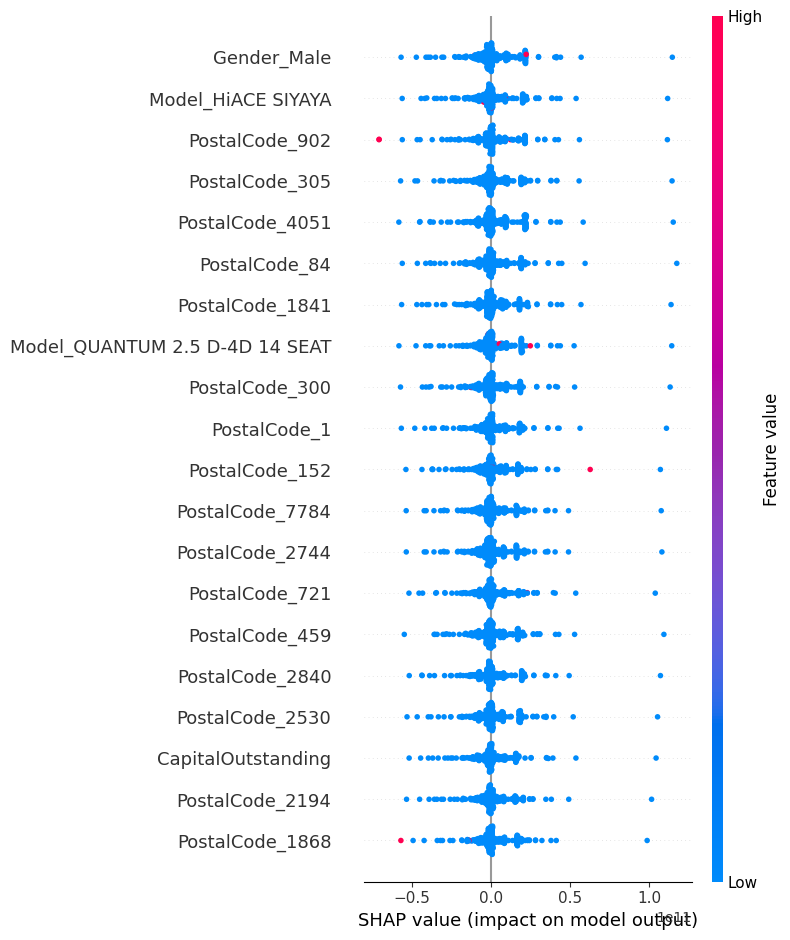

In [35]:
plt.figure()
shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)
plt.tight_layout()
plt.show()

Pick one example from X_sample:

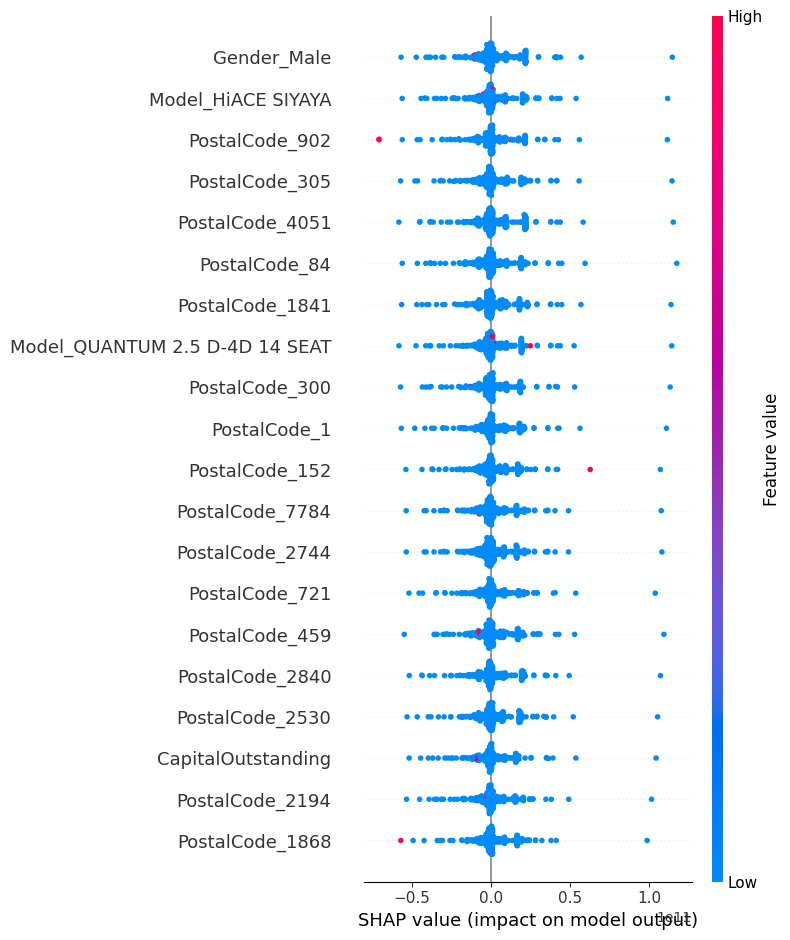

In [37]:
if isinstance(shap_values, list):
    shap_vals_plot = shap_values[0]
else:
    shap_vals_plot = shap_values

plt.figure()
shap.summary_plot(shap_vals_plot, X_sample, feature_names=feature_names, show=False)
plt.tight_layout()
plt.show()


In [38]:
row_idx = 0  # or any index < n_samples
shap.force_plot(
    explainer.expected_value,
    shap_vals_plot[row_idx],
    X_sample[row_idx],
    feature_names=feature_names,
)
